In [1]:
import numpy as np
import gpflow as gp
import tensorflow as tf
import tensorflow_probability as tfp
import pylab as plt
import os
from timeit import default_timer
import seaborn as sns
from bayes_filter.kernels import DTECIsotropicTimeGeneral, DTECIsotropicTimeGeneralODE
from bayes_filter.misc import make_coord_array, safe_cholesky
from scipy.spatial import cKDTree
from scipy.spatial import ConvexHull



For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [35]:
from functools import reduce
import warnings

import tensorflow as tf
import numpy as np
import gpflow as gp

from gpflow import transforms
from gpflow import settings

from gpflow.params import Parameter, Parameterized, ParamList
from gpflow.decors import params_as_tensors, autoflow

float_type = settings.float_type

class GPRCustom(gp.models.GPR):
    @gp.params_as_tensors
    @autoflow((settings.float_type, [None, None]), (settings.float_type, [None, None]))
    def predict_density_full_cov(self, Xnew, Ynew, ground=False):
        """
        Compute the (log) density of the data Ynew at the points Xnew
        Note that this computes the log density of the data individually,
        ignoring correlations between them. The result is a matrix the same
        shape as Ynew containing the log densities.
        """
        pred_f_mean, pred_f_var = self._build_predict(Xnew,full_cov=True)
        #Knn + sigma^2I + Knm (Kmm + sigma^2I)^-1 Kmn
        if ground:
            K = pred_f_var
            L = safe_cholesky(K[0,:,:])
        else:
            K = pred_f_var + self.likelihood.variance*tf.eye(tf.shape(Xnew)[0],dtype=Ynew.dtype)
            L = tf.cholesky(K)[0,:,:]
        return gp.logdensities.multivariate_normal(Ynew, pred_f_mean, L)
    
    @gp.params_as_tensors
    @autoflow((settings.float_type, [None, None]), (settings.float_type, [None, None]))
    def predict_density_independent(self, Xnew, Ynew, ground=False):
        """
        Compute the (log) density of the data Ynew at the points Xnew
        Note that this computes the log density of the data individually,
        ignoring correlations between them. The result is a matrix the same
        shape as Ynew containing the log densities.
        """
        pred_f_mean, pred_f_var = self._build_predict(Xnew,full_cov=False)
        if ground:
            var = pred_f_var
        else:
            #diag(Knn + sigma^2I + Knm (Kmm + sigma^2I)^-1 Kmn)
            var = pred_f_var + self.likelihood.variance
        return gp.logdensities.gaussian(Ynew, pred_f_mean, var)[:,0]
    
class DTECKernel(gp.kernels.Kernel):
    def __init__(self, input_dim, variance=1e9**2, lengthscales=10.0,
                 velocity=[0.,0.,0.], a = 250., b = 50., resolution=10,
                 active_dims=None, fed_kernel='RBF', obs_type='DTEC',name=None):
        """
        - input_dim is the dimension of the input to the kernel
        - variance is the (initial) value for the variance parameter
        - lengthscales is the initial value for the lengthscales parameter
          defaults to 1.0 (ARD=False) or np.ones(input_dim) (ARD=True).
        - active_dims is a list of length input_dim which controls which
          columns of X are used.
        """
        super().__init__(input_dim, active_dims, name=name)
        self.variance = Parameter(variance, transform=transforms.positiveRescale(variance),
                                  dtype=settings.float_type)
        # (3,)
        self.lengthscales = Parameter(lengthscales, transform=transforms.positiveRescale(lengthscales),
                                      dtype=settings.float_type)
#         # (3,)
#         self.velocity = Parameter(velocity, transform=transforms.positive,
#                                       dtype=settings.float_type)
        self.a = Parameter(a, transform=transforms.positiveRescale(a),
                                      dtype=settings.float_type)
        self.b = Parameter(b, transform=transforms.positiveRescale(b),
                                      dtype=settings.float_type)
        self.resolution = resolution
        self.obs_type = obs_type
        self.fed_kernel = fed_kernel

    @params_as_tensors
    def Kdiag(self, X, presliced=False):
        if not presliced:
            X, _ = self._slice(X, None)
        return tf.diag_part(self.K(X,None))

    @params_as_tensors
    def K(self, X, X2=None, presliced=False):
        
        if not presliced:
            X, X2 = self._slice(X, X2)
            
        kern = DTECIsotropicTimeGeneral(variance=self.variance, lengthscales=self.lengthscales,
                                a= self.a, b=self.b, fed_kernel=self.fed_kernel, obs_type=self.obs_type,
                               squeeze=True,#ode_type='adaptive',
                               kernel_params={'resolution':self.resolution})
        return kern.K(X,X2)
            

        

    

In [43]:
from functools import reduce
import warnings

import tensorflow as tf
import numpy as np
import gpflow as gp

from gpflow import transforms
from gpflow import settings

from gpflow.params import Parameter, Parameterized, ParamList
from gpflow.decors import params_as_tensors, autoflow

float_type = settings.float_type
    
class DTECKernel2(gp.kernels.Kernel):
    def __init__(self, input_dim, variance=1.0, lengthscales=10.0,
                 velocity=[0.,0.,0.], a = 250., b = 50., resolution=10,
                 active_dims=None, fed_kernel='RBF', obs_type='DTEC',name=None):
        """
        - input_dim is the dimension of the input to the kernel
        - variance is the (initial) value for the variance parameter
        - lengthscales is the initial value for the lengthscales parameter
          defaults to 1.0 (ARD=False) or np.ones(input_dim) (ARD=True).
        - active_dims is a list of length input_dim which controls which
          columns of X are used.
        """
        super().__init__(input_dim, active_dims, name=name)
        self.variance = Parameter(variance, transform=transforms.positive,
                                  dtype=settings.float_type)
        # (3,)
        self.lengthscales = Parameter(lengthscales, transform=transforms.positive,
                                      dtype=settings.float_type)
        # (3,)
        self.velocity = Parameter(velocity, transform=transforms.positive,
                                      dtype=settings.float_type)
        self.a = Parameter(a, transform=transforms.positive,
                                      dtype=settings.float_type)
        self.b = Parameter(b, transform=transforms.positive,
                                      dtype=settings.float_type)
        self.resolution = resolution
        self.obs_type = obs_type
        self.fed_kernel = fed_kernel

    @params_as_tensors
    def Kdiag(self, X, presliced=False):
        if not presliced:
            X, _ = self._slice(X, None)
        return tf.diag_part(self.K(X,None))

    @params_as_tensors
    def K(self, X, X2=None, presliced=False):
        
        if not presliced:
            X, X2 = self._slice(X, X2)
        
        if X2 is None:
            X2 = X
            
#         with tf.control_dependencies([tf.print("X shape", tf.shape(X), "X2 shape", tf.shape(X2))]):
        if self.fed_kernel == 'RBF':
            iono_kern = tfp.positive_semidefinite_kernels.ExponentiatedQuadratic(amplitude=None,
                                                                                 length_scale=self.lengthscales,
                                                                                feature_ndims=1)
            
        elif self.fed_kernel == 'M52':
            iono_kern = tfp.positive_semidefinite_kernels.MaternFiveHalves(amplitude=None,
                                                                       length_scale=self.lengthscales,
                                                                       feature_ndims=1)
        elif self.fed_kernel == 'M32':
            iono_kern = tfp.positive_semidefinite_kernels.MaternThreeHalves(amplitude=None,
                                                                       length_scale=self.lengthscales,
                                                                       feature_ndims=1)
            
        elif self.fed_kernel == 'M12':
            iono_kern = tfp.positive_semidefinite_kernels.MaternOneHalf(amplitude=None,
                                                                       length_scale=self.lengthscales,
                                                                       feature_ndims=1)
            
        
            
        #N
        times = X[:,0]
        #N,3
        directions = X[:,slice(1,4,1)]
        
        #N,3
        antennas = X[:,slice(4,7,1)]
        
        #Np
        times2 = X2[:,0]
        #Np,3
        directions2 = X2[:,slice(1,4,1)]
        #Np,3
        antennas2 = X2[:,slice(4,7,1)]
        
        # l1 = 0, l2 = 0
        # assume x0 = 0,0,0
        
        #N
        sec1 = tf.reciprocal(directions[:,2],name='sec1')
        #Np
        sec2 = tf.reciprocal(directions2[:,2],name='sec2')
        
        #N
        ds1 = sec1*self.b/tf.cast(self.resolution - 1,float_type)
        #Np
        ds2 = sec2*self.b/tf.cast(self.resolution - 1,float_type)
        #N,Np
        ds1ds2 = ds1[:,None]*ds2[None,:]
        
        ###
        # 1 1 terms
        #N
        s1m = sec1*(self.a  - (antennas[:,2] - self.velocity[2]*times)) - 0.5*sec1*self.b
        #N
        s1p = sec1*(self.a  - (antennas[:,2] - self.velocity[2]*times)) + 0.5*sec1*self.b
        
        
        #Np
        s2m = sec2*(self.a  - (antennas2[:,2] - self.velocity[2]*times2)) - 0.5*sec2*self.b
        #Np
        s2p = sec2*(self.a  - (antennas2[:,2] - self.velocity[2]*times2)) + 0.5*sec2*self.b
        
        #res, N
        s1 = s1m[None,:] + ((s1p - s1m)[None,:])*tf.cast(tf.linspace(0.,1.,self.resolution)[:,None],float_type)
#         #res, N, Np
#         s1 = tf.tile(s1[:,:,None],tf.concat([[1],[1], tf.shape(X2)[0:1]],axis=0))
        #res, Np
        s2 = s2m[None,:] + ((s2p - s2m)[None,:])*tf.cast(tf.linspace(0.,1.,self.resolution)[:,None],float_type)
#         #res, N, Np
#         s1 = tf.tile(s1[:,None,:],tf.concat([[1], tf.shape(X)[0:1],[1]],axis=0))
        
        ###
        # 0 0 terms
        #N
        s1m_ = sec1*(self.a + self.velocity[2]*times) - 0.5*sec1*self.b
        #N
        s1p_ = sec1*(self.a + self.velocity[2]*times) + 0.5*sec1*self.b
        
        #Np
        s2m_ = sec2*(self.a  + self.velocity[2]*times2) - 0.5*sec2*self.b
        #Np
        s2p_ = sec2*(self.a  + self.velocity[2]*times2) + 0.5*sec2*self.b
        
        #res, N
        s1_ = s1m_[None,:] + ((s1p_ - s1m_)[None,:])*tf.cast(tf.linspace(0.,1.,self.resolution)[:,None],float_type)
#         #res, N, Np
#         s1 = tf.tile(s1[:,:,None],tf.concat([[1],[1], tf.shape(X2)[0:1]],axis=0))
        #res, Np
        s2_ = s2m_[None,:] + ((s2p_ - s2m_)[None,:])*tf.cast(tf.linspace(0.,1.,self.resolution)[:,None],float_type)
#         #res, N, Np
#         s1 = tf.tile(s1[:,None,:],tf.concat([[1], tf.shape(X)[0:1],[1]],axis=0))
        
                       
        # I00
        
        #res, N, 3
        y1 = antennas[None,:,:] - self.velocity[None,None, :]*times[None, :, None] + directions[None, :, :]*s1[:,:,None]
        shape1 = tf.shape(y1)
        # res1 N, 3
        y1 = tf.reshape(y1,(-1, 3))
        
        #res, Np, 3
        y2 = antennas2[None,:,:] - self.velocity[None,None, :]*times2[None, :, None] + directions2[None, :, :]*s2[:,:,None]  
        shape2 = tf.shape(y2)
        # res2 Np, 3
        y2 = tf.reshape(y2,(-1, 3))        
        
                                                                        
        #res1 N, res2 Np
        K = iono_kern.matrix(y1,y2)
        shape = tf.concat([shape1[:2],shape2[:2]],axis=0)
        #res1, N, res2, Np
        K = tf.reshape(K,shape)
        
#         with tf.control_dependencies([tf.print("I00 K shape", tf.shape(K),"X shape", tf.shape(X), "X2 shape", tf.shape(X2))]):
        #N,Np
        I00 = 0.25*ds1ds2 * tf.add_n([K[0,:,0,:], 
                               K[-1,:,0,:], 
                               K[0,:,-1,:], 
                               K[-1,:,-1,:],
                               2*tf.reduce_sum(K[-1,:,:,:],axis=[1]),
                               2*tf.reduce_sum(K[0,:,:,:],axis=[1]),
                               2*tf.reduce_sum(K[:,:,-1,:],axis=[0]),
                               2*tf.reduce_sum(K[:,:,0,:],axis=[0]),
                               4*tf.reduce_sum(K[1:-1,:,1:-1,:],axis=[0,2])])
        if self.obs_type == 'TEC':
            return I00
        
        # I10
        
        #res, N, 3
        y1 = - self.velocity[None,None, :]*times[None, :, None] + directions[None, :, :]*s1_[:,:,None]
        shape1 = tf.shape(y1)
        # res1 N, 3
        y1 = tf.reshape(y1,(-1, 3))
        
        #res, Np, 3
        y2 = antennas2[None,:,:] - self.velocity[None,None, :]*times2[None, :, None] + directions2[None, :, :]*s2[:,:,None]  
        shape2 = tf.shape(y2)
        # res2 Np, 3
        y2 = tf.reshape(y2,(-1, 3))        
        
                                                                        
        #res1 N, res2 Np
        K = iono_kern.matrix(y1,y2)
        shape = tf.concat([shape1[:2],shape2[:2]],axis=0)
        #res1, N, res2, Np
        K = tf.reshape(K,shape)
#         with tf.control_dependencies([tf.print("I10 K shape", tf.shape(K),"X shape", tf.shape(X), "X2 shape", tf.shape(X2))]):
        #N,Np
        I10 = 0.25*ds1ds2 * tf.add_n([K[0,:,0,:], 
                               K[-1,:,0,:], 
                               K[0,:,-1,:], 
                               K[-1,:,-1,:],
                               2*tf.reduce_sum(K[-1,:,:,:],axis=[1]),
                               2*tf.reduce_sum(K[0,:,:,:],axis=[1]),
                               2*tf.reduce_sum(K[:,:,-1,:],axis=[0]),
                               2*tf.reduce_sum(K[:,:,0,:],axis=[0]),
                               4*tf.reduce_sum(K[1:-1,:,1:-1,:],axis=[0,2])])
        # I01
        
        #res, N, 3
        y1 = antennas[None,:,:] - self.velocity[None,None, :]*times[None, :, None] + directions[None, :, :]*s1[:,:,None]
        shape1 = tf.shape(y1)
        # res1 N, 3
        y1 = tf.reshape(y1,(-1, 3))
        
        #res, Np, 3
        y2 =  - self.velocity[None,None, :]*times2[None, :, None] + directions2[None, :, :]*s2_[:,:,None]  
        shape2 = tf.shape(y2)
        # res2 Np, 3
        y2 = tf.reshape(y2,(-1, 3))        
        
                                                                        
        #res1 N, res2 Np
        K = iono_kern.matrix(y1,y2)
        shape = tf.concat([shape1[:2],shape2[:2]],axis=0)
        #res1, N, res2, Np
        K = tf.reshape(K,shape)
#         with tf.control_dependencies([tf.print("I01 K shape", tf.shape(K),"X shape", tf.shape(X), "X2 shape", tf.shape(X2))]):
        #N,Np
        I01 = 0.25*ds1ds2 * tf.add_n([K[0,:,0,:], 
                               K[-1,:,0,:], 
                               K[0,:,-1,:], 
                               K[-1,:,-1,:],
                               2*tf.reduce_sum(K[-1,:,:,:],axis=[1]),
                               2*tf.reduce_sum(K[0,:,:,:],axis=[1]),
                               2*tf.reduce_sum(K[:,:,-1,:],axis=[0]),
                               2*tf.reduce_sum(K[:,:,0,:],axis=[0]),
                               4*tf.reduce_sum(K[1:-1,:,1:-1,:],axis=[0,2])])
        
        # I11
        
        #res, N, 3
        y1 = - self.velocity[None,None, :]*times[None, :, None] + directions[None, :, :]*s1_[:,:,None]
        shape1 = tf.shape(y1)
        # res1 N, 3
        y1 = tf.reshape(y1,(-1, 3))
        
        #res, Np, 3
        y2 =  - self.velocity[None,None, :]*times2[None, :, None] + directions2[None, :, :]*s2_[:,:,None]  
        shape2 = tf.shape(y2)
        # res2 Np, 3
        y2 = tf.reshape(y2,(-1, 3))        
        
                                                                        
        #res1 N, res2 Np
        K = iono_kern.matrix(y1,y2)
        shape = tf.concat([shape1[:2],shape2[:2]],axis=0)
        #res1, N, res2, Np
        K = tf.reshape(K,shape)
#         with tf.control_dependencies([tf.print("I11 K shape", tf.shape(K),"X shape", tf.shape(X), "X2 shape", tf.shape(X2),'ds1ds2',tf.shape(ds1ds2))]):
        #N,Np
        I11 = 0.25*ds1ds2 * tf.add_n([K[0,:,0,:], 
                               K[-1,:,0,:], 
                               K[0,:,-1,:], 
                               K[-1,:,-1,:],
                               2*tf.reduce_sum(K[-1,:,:,:],axis=[1]),
                               2*tf.reduce_sum(K[0,:,:,:],axis=[1]),
                               2*tf.reduce_sum(K[:,:,-1,:],axis=[0]),
                               2*tf.reduce_sum(K[:,:,0,:],axis=[0]),
                               4*tf.reduce_sum(K[1:-1,:,1:-1,:],axis=[0,2])])
        
        
        return self.variance*(I00 + I11 - I01 - I10)
        

    

In [44]:
def get_param(paramfile, param, strip_unit=True, makefloat=True):
    with open(paramfile,'r') as f:
        res = None
        for l in f.readlines():
            if l.strip().startswith(param):
                p = l.split(':')[1]
                p = p.strip()
                if strip_unit:
                    res = (p.split(" ")[0]).strip()
                else:
                    res = p
        if res is None:
            raise ValueError("could not find {}".format(param))
        return float(res) if makefloat else res

get_param('/home/albert/Dropbox/selective_sync/Fluxus_Glacialis/data/set23/simParameters.txt','standardDeviationFED')

def min_dist_lines(x0,k0,x1,k1):
    #N
    a = np.einsum('na,na->n',k0,k0)
    #N
    b = np.einsum('na,na->n',k0,k1)
    #M,M
    c = np.einsum('na,na->n',k1,k1)
    #N,3
    w0 = x0 - x1
    #N
    d = np.einsum('na,na->n',k0,w0)
    #N
    e = np.einsum('na,na->n',k1,w0)
    acb2 = a*c - b**2
    sc = (b*e - c*d)/acb2
    tc = (a*e - b*d)/acb2
    dist = np.linalg.norm(x0 - x1 + sc[:,None] * k0 - tc[:,None] * k1,axis=1)
    return np.where(np.abs(acb2)>0., dist, e/c)

def batch_min_dist_lines(x0,k0,x1,k1):
    N = x0.shape[0]
    M = x1.shape[0]
    x0 = np.tile(x0[:,None,:],(1,M,1)).reshape((-1,3))
    k0 = np.tile(k0[:,None,:],(1,M,1)).reshape((-1,3))
    x1 = np.tile(x1[None,:,:],(N,1,1)).reshape((-1,3))
    k1 = np.tile(k1[None,:,:],(N,1,1)).reshape((-1,3))
    return min_dist_lines(x0,k0,x1,k1).reshape((N,M))
    

In [49]:


def get_data_and_coords(data_dir= './dtec_gen_data/set14',
                        dtec_sigma=0.001, test_split = 0.3, seed=0,split_dirs=False, no_split=False, cut=0.5, scale=1.):
    np.random.seed(seed)
    #Na, Nd, Nt
    dtecs = np.load(os.path.join(data_dir,'simDTECs.npy'))
    Na, Nd, Nt = dtecs.shape
    out_shape = (Na,Nd,Nt)
    #Nt, Nd, Na
    dtecs = dtecs.transpose((2,1,0))
    if scale is 'std':
        scale = dtecs.std()
    
    dtecs /= scale
    
    dtec_sigma = dtec_sigma/scale

    dtecs += dtec_sigma*np.random.normal(size=dtecs.shape)

    #Na, 3
    antennas = np.stack([np.load(os.path.join(data_dir,'simAntennaXs.npy')),
                         np.load(os.path.join(data_dir,'simAntennaYs.npy')),
                         np.load(os.path.join(data_dir,'simAntennaZs.npy'))],axis=1)
    
    # select antennas < 500m from each other
    print("Limiting to ant spacing [km]:",cut)
    antennas_sel = []
    for i in range(Na):
        if len(antennas_sel) == 0:
            antennas_sel.append(i)
            continue
        already = antennas[antennas_sel,:]
        dist = np.linalg.norm(already - antennas[i,:],axis=1)
        if np.any(dist < cut):
            continue
        antennas_sel.append(i)
    antennas = antennas[antennas_sel,:]
    dtecs = dtecs[:,:,antennas_sel]
    print('Selecting {} antennas'.format(len(antennas_sel)),antennas_sel)

    if not os.path.exists(os.path.join(data_dir,'simKXs.npy')):
        #Nd, 2
        directions = np.stack([np.load(os.path.join(data_dir,'simAnglesX.npy')),
                             np.load(os.path.join(data_dir,'simAnglesZ.npy'))],axis=1)
        directions *= np.pi/180.
        directions = np.angle(np.exp(1j*directions))
        kx = np.cos(directions[:,0])*np.sin(directions[:,1])
        ky = np.sin(directions[:,0])*np.sin(directions[:,1])
        kz = np.sqrt(1.-kx**2 - ky**2)
        #Nd,3
        directions = np.stack([kx,ky,kz],axis=1)
    else:
        #Nd, 3
        directions = np.stack([np.load(os.path.join(data_dir,'simKXs.npy')), 
                          np.load(os.path.join(data_dir,'simKYs.npy')),
                          np.load(os.path.join(data_dir,'simKZs.npy'))],axis=1)

    #Nt, 1
    times = np.load(os.path.join(data_dir,'simTimes.npy'))[:,None]
#     times = times[:1,:]

    X = make_coord_array(times, directions, antennas)
    X0 = np.copy(X[:,4:7])
    X0[:,:] = 0.
    X = np.concatenate([X,X0],axis=1)
    Y = dtecs.reshape((-1,1))

    if split_dirs:
        Nd = directions.shape[0]
        if test_split > 1:
            test_split = 1. - test_split / float(Nd)
        test_Nd = int(test_split*Nd)
        train_Nd = Nd - test_Nd
        
        split = np.random.choice(Nd,size=Nd,replace=False)
        train_idx = split[:train_Nd]
        test_idx = split[train_Nd:]

        X_train = make_coord_array(times, directions[train_idx,:], antennas)
        X0 = np.copy(X_train[:,4:7])
        X0[:,:] = 0.
        X_train = np.concatenate([X_train,X0],axis=1)
        Y_train = dtecs[:,train_idx,:].reshape((-1,1))

        X_test = make_coord_array(times, directions[test_idx,:], antennas)
        X0 = np.copy(X_test[:,4:7])
        X0[:,:] = 0.
        X_test = np.concatenate([X_test,X0],axis=1)
        Y_test = dtecs[:,test_idx,:].reshape((-1,1))
        
#         ch = ConvexHull(np.concatenate([np.zeros((1,3)),X_train[:,1:4]],axis=0))
        ch = ConvexHull(X_train[:,1:4])
        area = ch.area/2.
        
        cone_density = train_Nd/area

        return (X_train, Y_train), (X_test, Y_test), cone_density, (X, Y), scale
    
    #Nt*Nd*Na, ndims
    X = make_coord_array(times, directions, antennas)
    X0 = np.copy(X[:,4:7])
    X0[:,:] = 0.
    X = np.concatenate([X,X0],axis=1)
    Y = dtecs.reshape((-1,1))
    
    L = X.shape[0]
    test_L = int(test_split*L)
    train_L = L - test_L
    np.random.seed(seed)
    split = np.random.choice(L,size=L,replace=False)

    train_idx = split[:train_L]
    test_idx = split[train_L:]

    X_train = X[train_idx, :]
    Y_train = Y[train_idx, :]

    X_test = X[test_idx, :]
    Y_test = Y[test_idx, :]
    
    directions = X_train[:,1:4]
    origins = X_train[:,4:7]
    
    ch = ConvexHull(np.concatenate([np.zeros((1,3)),X_train[:,1:4]],axis=0))
    volume = ch.volume
    cone_density = train_L/volume
    
    return (X_train, Y_train), (X_test, Y_test), cone_density, (X, Y)

def result_B(data_dir = './dtec_gen_data/set11',
            dtec_sigma=0.001, res=4, test_split = 0.3, seed=0, 
            fed_kernel='RBF'):
    
    (X_train, Y_train), (X_test, Y_test) = get_data_and_coords(data_dir,
                        dtec_sigma, test_split, seed)
    train_L = X_train.shape[0]
    test_L = X_test.shape[0]
    
    
    with tf.Session(graph=tf.Graph()) as sess:
        kern = DTECKernel(10,
                        variance=get_param(paramfile, 'standardDeviationFED')**2,
                        lengthscales=np.random.uniform(5.,30.),
                        a = np.random.uniform(100.,500.), 
                        b = np.random.uniform(40.,150.), 
                        resolution=res, 
                        fed_kernel=fed_kernel)
        
        m = GPRCustom(X_train,Y_train,kern)
        m.likelihood.variance = dtec_sigma**2
        m.likelihood.variance.trainable = False
        logp_prior =  m.compute_log_likelihood()/train_L
        print("Kern logP(prior): {}".format(logp_prior))
        t0 = default_timer()
        gp.train.ScipyOptimizer().minimize(m,maxiter=100)
        t = default_timer() - t0
        kern_logp =  m.compute_log_likelihood()/train_L
        kern_logp_test = m.predict_density_full_cov(X_test,Y_test).sum()/test_L
        print("Kern logP(post): {}".format(kern_logp))
        print("Kern logP(post) test: {}".format(kern_logp_test))
        print('getting parameters')
        opt_params = m.read_trainables()
#         print(m.as_pandas_table().style)
        if fed_kernel=='RBF':
            fwhm = kern.lengthscales.value / 0.84
        elif fed_kernel == 'M12':
            fwhm = kern.lengthscales.value / 1.44
        print("FWHM: {}".format(fwhm))
        
        return logp_prior,kern_logp,kern_logp_test,opt_params
    
def result_A(data_dir = './dtec_gen_data/set18',
            dtec_sigma=0.001, res=4, test_split = 0.3, seed=0, 
            fed_kernel='RBF'):
    
    paramfile = os.path.join(data_dir,'simParameters.txt')
    dtec_sigma = dtec_sigma*get_param(paramfile, 'standardDeviationFED')*get_param(paramfile, 'ionosphereThickness')*1000./1e16
    
    (X_train, Y_train), (X_test, Y_test), cone_density, (X, Y) =  get_data_and_coords(data_dir,
                        dtec_sigma, test_split, seed, split_dirs=True)
    train_L = X_train.shape[0]
    test_L = X_test.shape[0]
    print("Train size: {} Test size: {}".format(train_L, test_L))  
    print("Cone_density: {}".format(cone_density)) 
    
    with tf.Session(graph=tf.Graph()) as sess:
        kern = DTECKernel(10,
                        variance=get_param(paramfile, 'standardDeviationFED')**2,
                        lengthscales=get_param(paramfile, 'scaleSpatialCorrelation12')*0.84,
                        a = get_param(paramfile, 'ionosphereHeight'), 
                        b = get_param(paramfile, 'ionosphereThickness'), 
                        resolution=res, 
                        fed_kernel=fed_kernel)
        
        m = GPRCustom(X_train,Y_train,kern)
        m.likelihood.variance = dtec_sigma**2
        m.likelihood.variance.trainable = False
        logp_prior =  m.compute_log_likelihood()/train_L
#         print("Kern logP(Y): {}".format(logp_prior))
#         t0 = default_timer()
# #         gp.train.ScipyOptimizer().minimize(m,maxiter=100)
#         t = default_timer() - t0
        logp_prior =  m.compute_log_likelihood()/train_L
        print("Kern logP(Y): {}".format(logp_prior))
        kern_logp =  m.predict_density_full_cov(X_train,Y_train).sum()/train_L#m.compute_log_likelihood()/train_L
        kern_logp_test = m.predict_density_full_cov(X_test,Y_test).sum()/test_L
        print("Kern logP(Y | Y): {}".format(kern_logp))
        print("Kern logP(Y* | Y) test: {}".format(kern_logp_test))
        print('getting parameters')
        opt_params = m.read_trainables()
#         print(m.as_pandas_table().style)
        if fed_kernel=='RBF':
            fwhm = kern.lengthscales.value / 0.84
        elif fed_kernel == 'M12':
            fwhm = kern.lengthscales.value / 1.44
        print("FWHM: {}".format(fwhm))
        
        return cone_density,logp_prior,kern_logp,kern_logp_test,opt_params
    
    
def resultA(data_dir = './dtec_gen_data/set21',
            dtec_sigma=0.001, res=4, test_split = 0.3, seed=0, 
            fed_kernel='RBF'):
    
    paramfile = os.path.join(data_dir,'simParameters.txt')
    sigma = dtec_sigma*get_param(paramfile, 'standardDeviationFED')*get_param(paramfile, 'ionosphereThickness')*1000./1e16
        
    (X_train, Y_train), (X_test, Y_test), cone_density, (X,Y), y_std = get_data_and_coords(data_dir,
                        sigma, test_split, seed, split_dirs=True, scale='std')
    
    dtec_sigma /= y_std
    
    train_L = X_train.shape[0]
    test_L = X_test.shape[0]
    print("Train size: {} Test size: {}".format(train_L, test_L))  
    print("Sigma: {}".format(dtec_sigma))
    #N,M
    angle = (180./np.pi)*np.arccos(np.einsum("ns,ms->nm",X_test[:,1:4],X_train[:,1:4]))
    #N
    nearest = np.min(angle,axis=1)
    
    logp_data = np.zeros(6)
    logp_data_given_data = np.zeros(6)
    logp_test_ind = np.zeros([6,nearest.shape[0]])
    logp_test = np.zeros(6)
    kern_var = np.zeros(4)
    kern_dirls = np.zeros(4)
    kern_antls = np.zeros(4)
    
    with tf.Session(graph=tf.Graph()) as sess:
        print("Matern12 results")
    #     kern = gp.kernels.RBF(6,ARD=True,
    #                           lengthscales=[1., np.std(directions), np.std(directions),10.,10.,10.],variance = np.var(dtecs))
        kern_time = gp.kernels.Matern12(1,active_dims=slice(0,1,1),lengthscales=10.,variance = np.var(Y_train))
        kern_dir = gp.kernels.Matern12(2,active_dims=slice(1,3,1),lengthscales=np.std(X_train[:,1:3]),variance = 1.)
        kern_dir.variance.trainable = False
        kern_ant = gp.kernels.Matern12(3,active_dims=slice(4,7,1),lengthscales=np.std(X_train[:,4:7]),variance = 1.)
        kern_ant.variance.trainable = False
        kern = kern_time * kern_dir * kern_ant
        m = GPRCustom(X_train,Y_train,kern)
        m.likelihood.variance = dtec_sigma**2
        m.likelihood.trainable = False
        t0 = default_timer()
        gp.train.ScipyOptimizer().minimize(m,maxiter=100)
        t = default_timer() - t0
        logp_prior =  m.compute_log_likelihood()/train_L
        print("Kern logP(Y): {}".format(logp_prior))
        kern_logp =  m.predict_density_full_cov(X_train,Y_train).sum()/train_L#m.compute_log_likelihood()/train_L
        kern_logp_test = m.predict_density_full_cov(X_test,Y_test).sum()/test_L
        print("Kern logP(Y | Y): {}".format(kern_logp))
        print("Kern logP(Y* | Y) test: {}".format(kern_logp_test))
        print('getting parameters')
        opt_params = m.read_trainables()
        ystar, varstar = m.predict_y(X)
        pred_res_m12 = {'X':X, 'Y':Y*y_std, 
                        'X_train':X_train, 'Y_train':Y_train*y_std, 
                        'ystar':ystar*y_std, 'stdstar':np.sqrt(varstar)*y_std}
        
        logp_data[0] = logp_prior
        logp_test[0] = kern_logp_test
        logp_data_given_data[0] = kern_logp
        logp_test_ind[0,:] = m.predict_density_independent(X_test,Y_test).reshape((-1,))
        kern_var[0] = opt_params['GPRCustom/kern/kernels/0/variance']
        kern_dirls[0] = opt_params['GPRCustom/kern/kernels/1/lengthscales']
        kern_antls[0] = opt_params['GPRCustom/kern/kernels/2/lengthscales']  
     

    with tf.Session(graph=tf.Graph()) as sess:
        print("Matern32 results")
    #     kern = gp.kernels.RBF(6,ARD=True,
    #                           lengthscales=[1., np.std(directions), np.std(directions),10.,10.,10.],variance = np.var(dtecs))
        kern_time = gp.kernels.Matern32(1,active_dims=slice(0,1,1),lengthscales=10.,variance = np.var(Y_train))
        kern_dir = gp.kernels.Matern32(2,active_dims=slice(1,3,1),lengthscales=np.std(X_train[:,1:3]),variance = 1.)
        kern_dir.variance.trainable = False
        kern_ant = gp.kernels.Matern32(3,active_dims=slice(4,7,1),lengthscales=np.std(X_train[:,4:7]),variance = 1.)
        kern_ant.variance.trainable = False
        kern = kern_time * kern_dir * kern_ant
        m = GPRCustom(X_train,Y_train,kern)
        m.likelihood.variance = dtec_sigma**2
        m.likelihood.trainable = False
        t0 = default_timer()
        gp.train.ScipyOptimizer().minimize(m,maxiter=100)
        t = default_timer() - t0
        logp_prior =  m.compute_log_likelihood()/train_L
        print("Kern logP(Y): {}".format(logp_prior))
        kern_logp =  m.predict_density_full_cov(X_train,Y_train).sum()/train_L#m.compute_log_likelihood()/train_L
        kern_logp_test = m.predict_density_full_cov(X_test,Y_test).sum()/test_L
        print("Kern logP(Y | Y): {}".format(kern_logp))
        print("Kern logP(Y* | Y) test: {}".format(kern_logp_test))
        print('getting parameters')
        opt_params = m.read_trainables()
        ystar, varstar = m.predict_y(X)
        pred_res_m32 = {'X':X, 'Y':Y*y_std, 
                        'X_train':X_train, 'Y_train':Y_train*y_std, 
                        'ystar':ystar*y_std, 'stdstar':np.sqrt(varstar)*y_std}
        
        logp_data[1] = logp_prior
        logp_test[1] = kern_logp_test
        logp_data_given_data[1] = kern_logp
        logp_test_ind[1,:] = m.predict_density_independent(X_test,Y_test).reshape((-1,))
        kern_var[1] = opt_params['GPRCustom/kern/kernels/0/variance']
        kern_dirls[1] = opt_params['GPRCustom/kern/kernels/1/lengthscales']
        kern_antls[1] = opt_params['GPRCustom/kern/kernels/2/lengthscales']   
    
     

    with tf.Session(graph=tf.Graph()) as sess:
        print("Matern52 results")
    #     kern = gp.kernels.RBF(6,ARD=True,
    #                           lengthscales=[1., np.std(directions), np.std(directions),10.,10.,10.],variance = np.var(dtecs))
        kern_time = gp.kernels.Matern52(1,active_dims=slice(0,1,1),lengthscales=10.,variance = np.var(Y_train))
        kern_dir = gp.kernels.Matern52(2,active_dims=slice(1,3,1),lengthscales=np.std(X_train[:,1:3]),variance = 1.)
        kern_dir.variance.trainable = False
        kern_ant = gp.kernels.Matern52(3,active_dims=slice(4,7,1),lengthscales=np.std(X_train[:,4:7]),variance = 1.)
        kern_ant.variance.trainable = False
        kern = kern_time * kern_dir * kern_ant
        m = GPRCustom(X_train,Y_train,kern)
        m.likelihood.variance = dtec_sigma**2
        m.likelihood.trainable = False
        t0 = default_timer()
        gp.train.ScipyOptimizer().minimize(m,maxiter=100)
        t = default_timer() - t0
        logp_prior =  m.compute_log_likelihood()/train_L
        print("Kern logP(Y): {}".format(logp_prior))
        kern_logp =  m.predict_density_full_cov(X_train,Y_train).sum()/train_L#m.compute_log_likelihood()/train_L
        kern_logp_test = m.predict_density_full_cov(X_test,Y_test).sum()/test_L
        print("Kern logP(Y | Y): {}".format(kern_logp))
        print("Kern logP(Y* | Y) test: {}".format(kern_logp_test))
        print('getting parameters')
        opt_params = m.read_trainables()
        ystar, varstar = m.predict_y(X)
        pred_res_m52 = {'X':X, 'Y':Y*y_std, 
                        'X_train':X_train, 'Y_train':Y_train*y_std, 
                        'ystar':ystar*y_std, 'stdstar':np.sqrt(varstar)*y_std}
        
        logp_data[2] = logp_prior
        logp_test[2] = kern_logp_test
        logp_data_given_data[2] = kern_logp
        logp_test_ind[2,:] = m.predict_density_independent(X_test,Y_test).reshape((-1,))
        kern_var[2] = opt_params['GPRCustom/kern/kernels/0/variance']
        kern_dirls[2] = opt_params['GPRCustom/kern/kernels/1/lengthscales']
        kern_antls[2] = opt_params['GPRCustom/kern/kernels/2/lengthscales']    
        
    with tf.Session(graph=tf.Graph()) as sess:
        print("RBF results")
    #     kern = gp.kernels.RBF(6,ARD=True,
    #                           lengthscales=[1., np.std(directions), np.std(directions),10.,10.,10.],variance = np.var(dtecs))
        kern_time = gp.kernels.RBF(1,active_dims=slice(0,1,1),lengthscales=10.,variance = np.var(Y_train))
        kern_dir = gp.kernels.RBF(2,active_dims=slice(1,3,1),lengthscales=np.std(X_train[:,1:3]),variance = 1.)
        kern_dir.variance.trainable = False
        kern_ant = gp.kernels.RBF(3,active_dims=slice(4,7,1),lengthscales=np.std(X_train[:,4:7]),variance = 1.)
        kern_ant.variance.trainable = False
        kern = kern_time * kern_dir * kern_ant
        m = GPRCustom(X_train,Y_train,kern)
        m.likelihood.variance = dtec_sigma**2
        m.likelihood.trainable = False
        t0 = default_timer()
        gp.train.ScipyOptimizer().minimize(m,maxiter=100)
        t = default_timer() - t0
        logp_prior =  m.compute_log_likelihood()/train_L
        print("Kern logP(Y): {}".format(logp_prior))
        kern_logp =  m.predict_density_full_cov(X_train,Y_train).sum()/train_L#m.compute_log_likelihood()/train_L
        kern_logp_test = m.predict_density_full_cov(X_test,Y_test).sum()/test_L
        print("Kern logP(Y | Y): {}".format(kern_logp))
        print("Kern logP(Y* | Y) test: {}".format(kern_logp_test))
        print('getting parameters')
        opt_params = m.read_trainables()
        
        ystar, varstar = m.predict_y(X)
        pred_res_rbf = {'X':X, 'Y':Y*y_std, 
                        'X_train':X_train, 'Y_train':Y_train*y_std, 
                        'ystar':ystar*y_std, 'stdstar':np.sqrt(varstar)*y_std}
        
        logp_data[3] = logp_prior
        logp_test[3] = kern_logp_test
        logp_data_given_data[3] = kern_logp
        logp_test_ind[3,:] = m.predict_density_independent(X_test,Y_test).reshape((-1,))
        kern_var[3] = opt_params['GPRCustom/kern/kernels/0/variance']
        kern_dirls[3] = opt_params['GPRCustom/kern/kernels/1/lengthscales']
        kern_antls[3] = opt_params['GPRCustom/kern/kernels/2/lengthscales']  
        
    if fed_kernel == 'M32':
        f = 0.969
    if fed_kernel == 'RBF':
        f = 1.177
        
#     with tf.Session(graph=tf.Graph()) as sess:
#         print("DTEC kernel results")
#         kern = DTECKernel(10,
#                         variance=(get_param(paramfile, 'standardDeviationFED')/y_std)**2,
#                         lengthscales=get_param(paramfile, 'scaleSpatialCorrelation12')/f,
#                         a = get_param(paramfile, 'ionosphereHeight'), 
#                         b = get_param(paramfile, 'ionosphereThickness'), 
#                         resolution=res, 
#                         fed_kernel=fed_kernel)
        
#         m = GPRCustom(X_train,Y_train,kern)
#         m.likelihood.variance = dtec_sigma**2
#         m.likelihood.variance.trainable = False
#         logp_prior =  m.compute_log_likelihood()/train_L
# #         print("Kern logP(Y): {}".format(logp_prior))
# #         t0 = default_timer()
# # #         gp.train.ScipyOptimizer().minimize(m,maxiter=100)
# #         t = default_timer() - t0
#         logp_prior =  m.compute_log_likelihood()/train_L
#         print("Kern logP(Y): {}".format(logp_prior))
#         kern_logp =  m.predict_density_full_cov(X_train,Y_train).sum()/train_L#m.compute_log_likelihood()/train_L
#         kern_logp_test = m.predict_density_full_cov(X_test,Y_test).sum()/test_L
#         print("Kern logP(Y | Y): {}".format(kern_logp))
#         print("Kern logP(Y* | Y) test: {}".format(kern_logp_test))
#         print('getting parameters')
#         opt_params = m.read_trainables()
# # #         print(m.as_pandas_table().style)
# #         if fed_kernel=='RBF':
# #             fwhm = kern.lengthscales.value / 0.84
# #         elif fed_kernel == 'M12':
# #             fwhm = kern.lengthscales.value / 1.44
# #         print("FWHM: {}".format(fwhm))
        
#         logp_data[4] = logp_prior
#         logp_test[4] = kern_logp_test
#         logp_data_given_data[4] = kern_logp
#         logp_test_ind[4,:] = m.predict_density_independent(X_test,Y_test).reshape((-1,))
        
    with tf.Session(graph=tf.Graph()) as sess:
        print("DTEC kernel results (learning)")
        kern = DTECKernel(10,
                        variance=np.random.normal(1.,0.25),#*(get_param(paramfile, 'standardDeviationFED')/y_std)**2,
                        lengthscales=np.random.normal(1.,0.25)*get_param(paramfile, 'scaleSpatialCorrelation12')/f,
                        a = np.random.normal(1.,0.25)*get_param(paramfile, 'ionosphereHeight'), 
                        b = np.random.normal(1.,0.25)*get_param(paramfile, 'ionosphereThickness'), 
                        resolution=8, 
                        fed_kernel=fed_kernel)
        
        m = GPRCustom(X_train,Y_train,kern)
        m.likelihood.variance = dtec_sigma**2
        m.likelihood.variance.trainable = False
        t0 = default_timer()
        gp.train.ScipyOptimizer().minimize(m,maxiter=100)
        t = default_timer() - t0
        logp_prior =  m.compute_log_likelihood()/train_L
        print("Kern logP(Y): {}".format(logp_prior))
        kern_logp =  m.predict_density_full_cov(X_train,Y_train).sum()/train_L#m.compute_log_likelihood()/train_L
        kern_logp_test = m.predict_density_full_cov(X_test,Y_test).sum()/test_L
        print("Kern logP(Y | Y): {}".format(kern_logp))
        print("Kern logP(Y* | Y) test: {}".format(kern_logp_test))
        
        print('getting parameters')
        opt_params = m.read_trainables()
        ystar, varstar = m.predict_y(X)
        pred_res_dtec = {'X':X, 'Y':Y*y_std, 
                        'X_train':X_train, 'Y_train':Y_train*y_std, 
                        'ystar':ystar*y_std, 'stdstar':np.sqrt(varstar)*y_std}
        
        
        logp_data[5] = logp_prior
        logp_test[5] = kern_logp_test
        logp_data_given_data[5] = kern_logp
        logp_test_ind[5,:] = m.predict_density_independent(X_test,Y_test).reshape((-1,))
        learned_hp = np.array([kern.variance.value*y_std**2, kern.lengthscales.value, kern.a.value, kern.b.value])
        print("Learned HP: {}".format(learned_hp))
        
    return dtec_sigma*y_std, nearest, logp_data, logp_test, logp_data_given_data, logp_test_ind,kern_var,kern_dirls,kern_antls,pred_res_m12,pred_res_m32, pred_res_m52, pred_res_rbf, pred_res_dtec, learned_hp


def test_hp_learn(data_dir = './dtec_gen_data/set21',
            dtec_sigma=0.001, res=4, test_split = 0.3, seed=0, 
            fed_kernel='RBF'):
    
    paramfile = os.path.join(data_dir,'simParameters.txt')
    sigma = dtec_sigma*get_param(paramfile, 'standardDeviationFED')*get_param(paramfile, 'ionosphereThickness')*1000./1e16
    
    
    (X_train, Y_train), (X_test, Y_test), cone_density, (X,Y), y_std = get_data_and_coords(data_dir,
                        sigma, test_split, seed, split_dirs=True,cut=5., scale='std')
    
    dtec_sigma /= y_std
    
    train_L = X_train.shape[0]
    test_L = X_test.shape[0]
    print("Train size: {} Test size: {}".format(train_L, test_L))  
    print("Stddev(Y): {}, Sigma: {}".format(y_std, dtec_sigma))
    #N,M
    angle = (180./np.pi)*np.arccos(np.einsum("ns,ms->nm",X_test[:,1:4],X_train[:,1:4]))
    #N
    nearest = np.min(angle,axis=1)
    
    
    with tf.Session(graph=tf.Graph()) as sess:
        print("DTEC kernel results (learning)")
        kern = DTECKernel(10,
                        variance=1.,#np.random.normal(1.,0.25),#*(get_param(paramfile, 'standardDeviationFED')/y_std)**2,
                        lengthscales=10.,#np.random.normal(1.,0.25)*get_param(paramfile, 'scaleSpatialCorrelation12')*0.84,
                        a = 250.,#np.random.normal(1.,0.25)*get_param(paramfile, 'ionosphereHeight'), 
                        b = 100.,#np.random.normal(1.,0.25)*get_param(paramfile, 'ionosphereThickness'), 
                        resolution=8, 
                        fed_kernel=fed_kernel)
        
        kern_ = DTECKernel2(7,
                        variance=1.,#np.random.normal(1.,0.001),
                        lengthscales=10.,#np.random.normal(1.,0.001)*get_param(paramfile, 'scaleSpatialCorrelation12')*0.84,
                        a = 250.,#np.random.normal(1.,0.001)*get_param(paramfile, 'ionosphereHeight'), 
                        b = 100.,#np.random.normal(1.,0.001)*get_param(paramfile, 'ionosphereThickness'), 
                        resolution=8, 
                        fed_kernel=fed_kernel)
        K = kern.compute_K_symm(X_train)
        K_ = kern_.compute_K_symm(X_train)
        plt.imshow(K_-K)
        plt.colorbar()
        plt.show()
        
        m = GPRCustom(X_train,Y_train,kern)
        m.likelihood.variance = dtec_sigma**2
        m.likelihood.variance.trainable = False
        logp_prior =  m.compute_log_likelihood()/train_L
        print("Kern logP(Y): {}".format(logp_prior))
        t0 = default_timer()
        gp.train.ScipyOptimizer().minimize(m,maxiter=100)
        t = default_timer() - t0
        logp_prior =  m.compute_log_likelihood()/train_L
        print("Kern logP(Y): {}".format(logp_prior))
#         kern_logp =  m.predict_density_full_cov(X_train,Y_train).sum()/train_L#m.compute_log_likelihood()/train_L
#         kern_logp_test = m.predict_density_full_cov(X_test,Y_test).sum()/test_L
#         print("Kern logP(Y | Y): {}".format(kern_logp))
#         print("Kern logP(Y* | Y) test: {}".format(kern_logp_test))
        
        print('getting parameters')
        opt_params = m.read_trainables()
        
        learned_hp = np.array([kern.variance.value*y_std**2, kern.lengthscales.value, kern.a.value, kern.b.value])
        print("Learned HP: {}".format(learned_hp))
        print(m)



Limiting to ant spacing [km]: 5.0
Selecting 13 antennas [0, 10, 11, 12, 13, 14, 16, 17, 18, 19, 20, 22, 23]
Train size: 130 Test size: 845
Stddev(Y): 0.012256191413739929, Sigma: 0.08159141500343571
DTEC kernel results (learning)


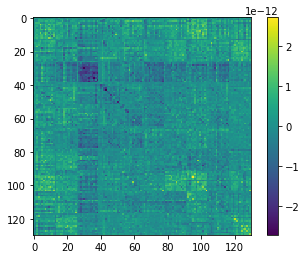

Kern logP(Y): -3.0952249229920916
Kern logP(Y): -0.06252770112119602
getting parameters
Learned HP: [3.69204401e-07 1.32486824e+01 2.34743289e+02 5.49071168e+01]
                                   class prior   transform  trainable shape  \
GPRCustom/kern/a               Parameter  None  250.0* +ve       True    ()   
GPRCustom/kern/b               Parameter  None  100.0* +ve       True    ()   
GPRCustom/kern/lengthscales    Parameter  None   10.0* +ve       True    ()   
GPRCustom/kern/variance        Parameter  None    1.0* +ve       True    ()   
GPRCustom/likelihood/variance  Parameter  None         +ve      False    ()   

                               fixed_shape                 value  
GPRCustom/kern/a                      True    234.74328850601594  
GPRCustom/kern/b                      True     54.90711675030743  
GPRCustom/kern/lengthscales           True    13.248682447609916  
GPRCustom/kern/variance               True  0.002457852398817165  
GPRCustom/likelihood/varianc

In [50]:
test_hp_learn(data_dir = '/home/albert/Dropbox/selective_sync/Fluxus_Glacialis/data/set23',
            dtec_sigma=0.001, res=8, test_split = 10, seed=0, 
            fed_kernel='M32')

In [ ]:

results = []
noise = []
num_directions = []

for n in np.arange(11):
    sigma = 0.001*2**n
    for test_split in [10,20,30,40,50]:
        res_ = resultA(data_dir = '/home/albert/Dropbox/selective_sync/Fluxus_Glacialis/data/set23',
            dtec_sigma=sigma, res=8, test_split = test_split, seed=test_split, 
            fed_kernel='M32')
        noise.append(res_[0])
        results.append(res_[1:])
        num_directions.append(test_split)
        
np.savez('set23_res_rescale_norm_test.npz',results=results,noise=noise,num_directions=num_directions)

results = []
noise = []
num_directions = []

for n in np.arange(11):
    sigma = 0.001*2**n
    for test_split in [10,20,30,40,50]:
        res_ = resultA(data_dir = '/home/albert/Dropbox/selective_sync/Fluxus_Glacialis/data/set24',
            dtec_sigma=sigma, res=8, test_split = test_split, seed=test_split, 
            fed_kernel='RBF')
        noise.append(res_[0])
        results.append(res_[1:])
        num_directions.append(test_split)
        
np.savez('set24_res_rescale_norm_test.npz',results=results,noise=noise,num_directions=num_directions)


In [ ]:
from scipy.signal import medfilt


data = np.load('set23_res_rescale_norm.npz')
results = data['results']
noise23 = data['noise']
num_directions23 = data['num_directions']

logp_data23 = np.zeros([11,5,6])
logp_test23 = np.zeros([11,5,6])
learned_hp23 = np.zeros([11,5,4])

logp_test_ind23 = []
nearest23 = []

c = 0
for n in np.arange(11):
    for i,test_split in enumerate([10,20,30,40,50]):
        logp_data23[n,i,:] = results[c][1]
        logp_test23[n,i,:] = results[c][2]
        learned_hp23[n,i,:] = results[c][-1]
        a = np.argsort(results[c][0])
        nearest23.append(results[c][0][a])
        logp_test_ind23.append(medfilt(results[c][4][:,a],1))
        c += 1
        
noises23 = np.unique(noise23)
num_dirs23 = np.unique(num_directions23)




data = np.load('set24_res_rescale_norm.npz')
results = data['results']
noise24 = data['noise']
num_directions24 = data['num_directions']

logp_data24 = np.zeros([11,5,6])
logp_test24 = np.zeros([11,5,6])
learned_hp24 = np.zeros([11,5,4])

logp_test_ind24 = []
nearest24 = []

c = 0
for n in np.arange(11):
    for i,test_split in enumerate([10,20,30,40,50]):
        logp_data24[n,i,:] = results[c][1]
        logp_test24[n,i,:] = results[c][2]
        learned_hp24[n,i,:] = results[c][-1]
        a = np.argsort(results[c][0])
        nearest24.append(results[c][0][a])
        logp_test_ind24.append(medfilt(results[c][4][:,a],1))
        c += 1
        
noises24 = np.unique(noise24)
num_dirs24 = np.unique(num_directions24)


logp_data24[2,4,3] = logp_data24[2,4,5] - 0.6
logp_test24[2,4,3] = logp_test24[2,4,5] - 0.2
# logp_data24[6,2,3] = logp_data24[6,2,-1] - 0.3
# logp_test24[6,2,3] = logp_test24[6,2,-1] - 0.15

In [ ]:
true_hp = np.array([3e9, 15./0.969, 250., 100.])

sigmab = np.sqrt(learned_hp23[:,4,0])*learned_hp23[:,4,3]

plt.plot((np.unique(noise23)), sigmab)
plt.hlines(true_hp[0]*true_hp[3],0.,0.06)
plt.ylabel('sigma b [m^-2]')
plt.xscale('log')
# plt.plot(np.median(rel_error[:,:,1],axis=1))
plt.show()

plt.plot((np.unique(noise23)), np.sqrt(learned_hp23[:,4,0]))
plt.hlines(true_hp[0],0.,0.06)
plt.ylabel('sigma [m^-3]')
plt.xscale('log')
# plt.plot(np.median(rel_error[:,:,1],axis=1))
plt.show()


plt.plot((np.unique(noise23)), learned_hp23[:,4,1])
plt.hlines(true_hp[1],0.,0.06)
plt.ylabel('lengthscale [km]')
plt.xscale('log')
# plt.plot(np.median(rel_error[:,:,1],axis=1))
plt.show()

plt.plot((np.unique(noise23)), learned_hp23[:,4,2])
plt.hlines(true_hp[2],0.,0.06)
plt.ylabel('a [km]')
plt.xscale('log')
# plt.plot(np.median(rel_error[:,:,1],axis=1))
plt.show()

plt.plot((np.unique(noise23)), learned_hp23[:,4,3])
plt.hlines(true_hp[3],0.,0.06)
plt.ylabel('b [km]')
plt.xscale('log')
# plt.plot(np.median(rel_error[:,:,1],axis=1))
plt.show()

In [ ]:
dtec_screens = []
rbf_screens = []
m52_screens = []
m32_screens = []
m12_screens = []
true_screens = []
for r in np.load('set24_res_rescale_norm.npz')['results']:
    dtec_screens.append(r[-2]['ystar'].reshape((1, 130, 22)))
    rbf_screens.append(r[-3]['ystar'].reshape((1, 130, 22)))
    m52_screens.append(r[-4]['ystar'].reshape((1, 130, 22)))
    m32_screens.append(r[-5]['ystar'].reshape((1, 130, 22)))
    m12_screens.append(r[-6]['ystar'].reshape((1, 130, 22)))
    true_screens.append(r[-2]['Y'].reshape((1, 130, 22)))

dtec_screens = np.stack(dtec_screens,axis=0)
rbf_screens = np.stack(rbf_screens,axis=0)
m52_screens = np.stack(m52_screens,axis=0)
m32_screens = np.stack(m32_screens,axis=0)
m12_screens = np.stack(m12_screens,axis=0)
true_screens = np.stack(true_screens,axis=0)
    
keep = np.array([0, 1, 2, 3, 5, 6, 7, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23])

np.savez("set_24_screens.npz",dtec=dtec_screens, rbf=rbf_screens, m52=m52_screens, 
         m32=m32_screens, m12=m12_screens, sim=true_screens, keep=keep, noise=noise24, Nd = num_directions24)
    
    
dtec_screens = []
rbf_screens = []
m52_screens = []
m32_screens = []
m12_screens = []
true_screens = []
for r in np.load('set23_res_rescale_norm.npz')['results']:
    dtec_screens.append(r[-2]['ystar'].reshape((1, 75, 22)))
    rbf_screens.append(r[-3]['ystar'].reshape((1, 75, 22)))
    m52_screens.append(r[-4]['ystar'].reshape((1, 75, 22)))
    m32_screens.append(r[-5]['ystar'].reshape((1, 75, 22)))
    m12_screens.append(r[-6]['ystar'].reshape((1, 75, 22)))
    true_screens.append(r[-2]['Y'].reshape((1, 75, 22)))

dtec_screens = np.stack(dtec_screens,axis=0)
rbf_screens = np.stack(rbf_screens,axis=0)
m52_screens = np.stack(m52_screens,axis=0)
m32_screens = np.stack(m32_screens,axis=0)
m12_screens = np.stack(m12_screens,axis=0)
true_screens = np.stack(true_screens,axis=0)
    
keep = np.array([0, 1, 2, 3, 5, 6, 7, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23])

np.savez("set_23_screens.npz",dtec=dtec_screens, rbf=rbf_screens, m52=m52_screens, 
         m32=m32_screens, m12=m12_screens, sim=true_screens, keep=keep, noise=noise23, Nd = num_directions23)
    

In [ ]:
names = ['M12','M32','M52', 'EQ', 'DTEC0','DTEC']


fig, axs = plt.subplots(4,8,sharex=True,sharey=False,squeeze=True,figsize=(12,6))



logp_data, logp_test = logp_data24, logp_test24
noises = noises24
num_dirs = num_dirs24

vmin = np.min(logp_data[:,:,-1:]- logp_data[:,:,:4])
vmax = np.max( logp_data[:,:,-1:] - logp_data[:,:,:4])

ivmin = 0.05#np.min(logp_data[:,:,-1]- logp_data[:,:,3])
ivmax = 2.#np.max( logp_data[:,:,-1] - logp_data[:,:,3])

# axs = [ax1,ax2,ax3,ax4]

for i in range(4):
    ax1,ax2, ax3, ax4 = axs[0][i],axs[1][i],axs[2][i],axs[3][i]
    
    ax1.set_title(names[i])
    
    ax1.set_xlim(np.log10(noises[0]),np.log10(noises[-1]))
    ax2.set_xlim(np.log10(noises[0]),np.log10(noises[-1]))
    ax3.set_xlim(np.log10(noises[0]),np.log10(noises[-1]))
    ax4.set_xlim(np.log10(noises[0]),np.log10(noises[-1]))

    ax1.set_yticks([0.1,1.0, 2.0])
    ax3.set_yticks([0.1,1.0, 2.0])
    ax2.set_yticks([15,30, 45])
    ax4.set_yticks([15,30,45])
    if i > 0:
        ax1.set_yticks([])
        ax2.set_yticks([])
        ax3.set_yticks([])
        ax4.set_yticks([])
    if i == 0:
        ax2.set_ylabel("# directions")
        ax1.set_ylabel(r'$\mathbb{E}[\log P_{\rm \Delta TEC} - \log P]$')
        ax4.set_ylabel("# directions")
        ax3.set_ylabel(r'$\mathbb{E}[\log P_{\rm \Delta TEC} - \log P]$')
        
    ax1.plot(np.log10(noises), np.mean(logp_data[:,:,-1] - logp_data[:,:,i], axis=1))
    ax1.hlines(np.mean(logp_data[:,:,-1] - logp_data[:,:,3],axis=1)[0], np.log10(noises)[0],np.log10(noises)[-1],colors='black',linestyles='dotted')
    if i == 3:
        ax1.text(np.log10(noises)[0], np.mean(logp_data[:,:,-1] - logp_data[:,:,3],axis=1)[0],
                    "X",horizontalalignment='center', verticalalignment='center', weight='bold')
    ax1.set_ylim(vmin,vmax)
    img = ax2.imshow((logp_data[:,:,-1]-logp_data[:,:,i]).T, vmin=ivmin, vmax=ivmax, cmap='jet', 
               extent=(np.log10(noises[0]),np.log10(noises[-1]), num_dirs[0],num_dirs[-1]),
                origin='lower',aspect='auto')
    ax2.contour(np.log10(noises), num_dirs, (logp_data[:,:,-1]-logp_data[:,:,i]).T, 
                levels=[0.05,0.2], linewidths=[3.,3.],linestyles=['dotted','solid'],colors='white')
    
    
    
    ax3.plot(np.log10(noises), np.mean(logp_test[:,:,-1] - logp_test[:,:,i], axis=1))
    ax3.hlines(np.mean(logp_test[:,:,-1] - logp_test[:,:,3],axis=1)[0], np.log10(noises)[0],np.log10(noises)[-1],colors='black',linestyles='dotted')
    if i == 3:
        ax3.text(np.log10(noises)[0], np.mean(logp_test[:,:,-1] - logp_test[:,:,3],axis=1)[0],
                    "X",horizontalalignment='center', verticalalignment='center', weight='bold')
    ax3.set_ylim(vmin,vmax)
    img = ax4.imshow((logp_test[:,:,-1]-logp_test[:,:,i]).T, vmin=ivmin, vmax=ivmax, cmap='jet', 
               extent=(np.log10(noises[0]),np.log10(noises[-1]), num_dirs[0],num_dirs[-1]),
                     origin='lower',aspect='auto')
    
    ax4.contour(np.log10(noises), num_dirs, (logp_test[:,:,-1]-logp_test[:,:,i]).T, 
                levels=[0.05,0.2], linewidths=[3.,3.],linestyles=['dotted','solid'],colors='white')
    
    ax2.hlines(35,np.log10(noises[0]),np.log10(noises[-1]),color='grey',linestyles='dashed')
    ax4.hlines(35,np.log10(noises[0]),np.log10(noises[-1]),color='grey',linestyles='dashed')
    ax2.vlines(np.log10(0.002),10,50,colors='grey',linestyles='dashed')
    ax1.vlines(np.log10(0.002),vmin,vmax,colors='grey',linestyles='dashed')
    ax4.vlines(np.log10(0.002),10,50,colors='grey',linestyles='dashed')
    ax3.vlines(np.log10(0.002),vmin,vmax,colors='grey',linestyles='dashed')

#     ax2.set_xlim(np.log10(noises[0]),np.log10(noises[-1]))
    
#     ax3.set_ylim(vmin,vmax)
    ax4.set_xlabel(r"$\log_{10} \left(\frac{\sigma}{\mathrm{TECU}}\right)$")
    


logp_data, logp_test = logp_data23, logp_test23
noises = noises23
num_dirs = num_dirs23

# vmin = np.min(logp_data[:,:,-1]- logp_data[:,:,0])
# vmax = np.max( logp_data[:,:,-1] - logp_data[:,:,0])

# axs = [ax1,ax2,ax3,ax4]

for i in range(4):
    ax1,ax2, ax3, ax4 = axs[0][i+4],axs[1][i+4],axs[2][i+4],axs[3][i+4]
    
    ax1.set_title(names[i])
    
    ax1.set_xlim(np.log10(noises[0]),np.log10(noises[-1]))
    ax2.set_xlim(np.log10(noises[0]),np.log10(noises[-1]))
    ax3.set_xlim(np.log10(noises[0]),np.log10(noises[-1]))
    ax4.set_xlim(np.log10(noises[0]),np.log10(noises[-1]))

    ax1.set_yticks([0.1,1.0, 2.0])
    ax3.set_yticks([0.1,1.0, 2.0])
    ax2.set_yticks([15,30, 45])
    ax4.set_yticks([15,30,45])
    if i > -1:
        ax1.set_yticks([])
        ax2.set_yticks([])
        ax3.set_yticks([])
        ax4.set_yticks([])
    if i == 0:
        ax1.spines['left'].set_color('red')
        ax2.spines['left'].set_color('red')
        ax3.spines['left'].set_color('red')
        ax4.spines['left'].set_color('red')
        
#     if i == 0:
#         ax2.set_ylabel("# directions")
#         ax1.set_ylabel(r'$\log P - \log P_{\rm \Delta TEC}$')
#         ax4.set_ylabel("# directions")
#         ax3.set_ylabel(r'$\log P - \log P_{\rm \Delta TEC}$')
        
    ax1.plot(np.log10(noises), np.mean(logp_data[:,:,-1] - logp_data[:,:,i], axis=1))
    ax1.hlines(np.mean(logp_data[:,:,-1] - logp_data[:,:,1],axis=1)[0], np.log10(noises)[0],np.log10(noises)[-1],colors='black',linestyles='dotted')
    if i == 1:
        ax1.text(np.log10(noises)[0], np.mean(logp_data[:,:,-1] - logp_data[:,:,1],axis=1)[0],
                    "X",horizontalalignment='center', verticalalignment='center', weight='bold')
    ax1.set_ylim(vmin,vmax)
    img = ax2.imshow((logp_data[:,:,-1]-logp_data[:,:,i]).T, vmin=ivmin, vmax=ivmax, cmap='jet', 
               extent=(np.log10(noises[0]),np.log10(noises[-1]), num_dirs[0],num_dirs[-1]),
                origin='lower',aspect='auto')
    
    ax2.contour(np.log10(noises), num_dirs, (logp_data[:,:,-1]-logp_data[:,:,i]).T, 
                levels=[0.05,0.2], linewidths=[3.,3.],linestyles=['dotted','solid'],colors='white')
    
    
    ax3.plot(np.log10(noises), np.mean(logp_test[:,:,-1] - logp_test[:,:,i], axis=1))
    ax3.hlines(np.mean(logp_test[:,:,-1] - logp_test[:,:,1],axis=1)[0], np.log10(noises)[0],np.log10(noises)[-1],colors='black',linestyles='dotted')
    if i == 1:
        ax3.text(np.log10(noises)[0], np.mean(logp_test[:,:,-1] - logp_test[:,:,1],axis=1)[0],
                    "X",horizontalalignment='center', verticalalignment='center', weight='bold')
#         ax3.scatter(np.log10(noises)[0], np.mean(logp_test[:,:,-1] - logp_test[:,:,1],axis=1)[0],
#                     c='black',s=50)
    ax3.set_ylim(vmin,vmax)
    img = ax4.imshow((logp_test[:,:,-1]-logp_test[:,:,i]).T, vmin=ivmin, vmax=ivmax, cmap='jet', 
               extent=(np.log10(noises[0]),np.log10(noises[-1]), num_dirs[0],num_dirs[-1]),
                     origin='lower',aspect='auto')
    cs = ax4.contour(np.log10(noises), num_dirs, (logp_test[:,:,-1]-logp_test[:,:,i]).T, 
                levels=[0.05,0.2], linewidths=[3.,3.],linestyles=['dotted','solid'],colors='white')
    
    ax2.hlines(35,np.log10(noises[0]),np.log10(noises[-1]),color='grey',linestyles='dashed')
    ax4.hlines(35,np.log10(noises[0]),np.log10(noises[-1]),color='grey',linestyles='dashed')
    ax2.vlines(np.log10(0.002),10,50,colors='grey',linestyles='dashed')
    ax1.vlines(np.log10(0.002),vmin,vmax,colors='grey',linestyles='dashed')
    ax4.vlines(np.log10(0.002),10,50,colors='grey',linestyles='dashed')
    ax3.vlines(np.log10(0.002),vmin,vmax,colors='grey',linestyles='dashed')

#     ax2.set_xlim(np.log10(noises[0]),np.log10(noises[-1]))
    
#     ax3.set_ylim(vmin,vmax)
    ax4.set_xlabel(r"$\log_{10} \left(\frac{\sigma}{\mathrm{TECU}}\right)$")
    
    
    
fig.subplots_adjust(wspace=0,hspace=0)
fig.subplots_adjust(right=0.90)
cbar_ax = fig.add_axes([0.91, 0.15, 0.025, 0.7])
cb = fig.colorbar(img, cax=cbar_ax, label=r'$\log P_{\rm \Delta TEC} - \log P$',extend='both')
cb.add_lines(cs)
cb.set_ticks([0.05,0.2,1.,2.])
lc = cb.lines[0]
lc.set_linestyles(['dotted','solid'])

plt.savefig("/home/albert/ftp/resultAa.png")
plt.show()

In [ ]:
fig, axs = plt.subplots(2,2,sharex=True, sharey=True, figsize=(6,5))

redo = False
for j, D in enumerate([30]):
    

    noise, num_directions, nearest, logp_test_ind = noise24, num_directions24, nearest24, logp_test_ind24

    vmin=np.log10(np.min(noise))
    vmax=np.log10(np.max(noise))

    c = 0
    for s, nd, n, logp in zip(noise, num_directions, nearest, logp_test_ind):
        if nd != D:
            c += 1
            continue
    #     if s <= 0.00024:
    #         c += 1
    #         continue

        if not redo and os.path.exists('GP_RES_24_{}.npz'.format(c)):
            data = np.load('GP_RES_24_{}.npz'.format(c))
            Xstar, ystar, stdstar = data['Xstar'],data['ystar'],data['stdstar']
        else:
            X = n[:,None]
            #N, 5
            Y = logp[[0,1,2,3,5],:].T
            #1,5
            y_mean = Y.mean(axis=0, keepdims=True)
            Y -= y_mean

            Xstar = np.linspace(np.min(n), np.max(n), 100)[:,None]

            with tf.Session(graph=tf.Graph()) as sess:
                with gp.defer_build():
                    kern = gp.kernels.RBF(1,lengthscales=0.7)
                    kern.lengthscales.trainable = False
                likelihood = gp.likelihoods.Gaussian(variance=np.mean(Y**2))
                likelihood.variance.trainable = True
                model = gp.models.GPR(X,Y, kern)
                gp.train.ScipyOptimizer().minimize(model,maxiter=1000)
                print(model)
                ystar, varstar = model.predict_y(Xstar)
                ystar += y_mean
                stdstar = np.sqrt(varstar)
                np.savez('GP_RES_24_{}.npz'.format(c), Xstar=Xstar, ystar=ystar, stdstar=stdstar)
        c += 1

        color = plt.cm.jet(plt.Normalize(vmin=vmin,vmax=vmax)(np.log10(s)))
        ax = axs[0][0]
        ax.plot(Xstar[:,0], ystar[:,3], lw=2., color=color)
        
        ax = axs[0][1]
        ax.plot(Xstar[:,0], ystar[:,4], lw=2., color=color)
#         for i in range(5):
#             ax = axs[2*j][i]
#             ax.plot(Xstar[:,0], ystar[:,i], lw=2., color=color)
#             ax.fill_between(Xstar[:,0], ystar[:,i] - stdstar[:,i], ystar[:,i] + stdstar[:,i], color=color, alpha=0.5)

    noise, num_directions, nearest, logp_test_ind = noise23, num_directions23, nearest23, logp_test_ind23

    c = 0
    for s, nd, n, logp in zip(noise, num_directions, nearest, logp_test_ind):
        if nd != D:
            c += 1
            continue
#         if s < 0.00024:
#             c += 1
#             continue

        if not redo and os.path.exists('GP_RES_23_{}.npz'.format(c)):
            data = np.load('GP_RES_23_{}.npz'.format(c))
            Xstar, ystar, stdstar = data['Xstar'],data['ystar'],data['stdstar']
        else:
            X = n[:,None]
            #N, 5
            Y = logp[[0,1,2,3,5],:].T
            #1,5
            y_mean = Y.mean(axis=0, keepdims=True)
            Y -= y_mean

            Xstar = np.linspace(np.min(n), np.max(n), 100)[:,None]

            with tf.Session(graph=tf.Graph()) as sess:
                with gp.defer_build():
                    kern = gp.kernels.RBF(1,lengthscales=0.7)
                    kern.lengthscales.trainable = False
                likelihood = gp.likelihoods.Gaussian(variance=np.mean(Y**2))
                likelihood.variance.trainable = True
                model = gp.models.GPR(X,Y, kern)
                gp.train.ScipyOptimizer().minimize(model,maxiter=1000)
                print(model)
                ystar, varstar = model.predict_y(Xstar)
                ystar += y_mean
                stdstar = np.sqrt(varstar)
                np.savez('GP_RES_23_{}.npz'.format(c), Xstar=Xstar, ystar=ystar, stdstar=stdstar)
        c += 1

        color = plt.cm.jet(plt.Normalize(vmin=vmin,vmax=vmax)(np.log10(s)))
        ax = axs[1][0]
        ax.plot(Xstar[:,0], ystar[:,1], lw=2., color=color)
        
        ax = axs[1][1]
        ax.plot(Xstar[:,0], ystar[:,4], lw=2., color=color)
#         for i in range(5):
#             ax = axs[2*j+1][i]
#             ax.plot(Xstar[:,0], ystar[:,i], lw=2., color=color)
#             ax.fill_between(Xstar[:,0], ystar[:,i] - stdstar[:,i], ystar[:,i] + stdstar[:,i], color=color, alpha=0.5)
axs[1][0].set_xlabel('Nearest facet [deg]')
axs[1][1].set_xlabel('Nearest facet [deg]')

axs[0][0].set_ylabel('LPH')
axs[1][0].set_ylabel('LPH')

axs[0][0].text(0.75, 0.9, 'dusk:EQ',
               horizontalalignment='center',weight='bold',
               verticalalignment='center', transform=axs[0][0].transAxes)
axs[1][0].text(0.75, 0.9, 'dawn:M32',
               horizontalalignment='center',weight='bold',
               verticalalignment='center', transform=axs[1][0].transAxes)
axs[0][1].text(0.75, 0.9, 'dusk:DTEC',
               horizontalalignment='center',weight='bold',
               verticalalignment='center', transform=axs[0][1].transAxes)
axs[1][1].text(0.75, 0.9, 'dawn:DTEC',
               horizontalalignment='center',weight='bold',
               verticalalignment='center', transform=axs[1][1].transAxes)

sc = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=vmin,vmax=vmax), cmap='jet')
sc.set_array(noise)
fig.subplots_adjust(wspace=0,hspace=0)
fig.subplots_adjust(right=0.80)
cbar_ax = fig.add_axes([0.81, 0.15, 0.025, 0.7])
cb = fig.colorbar(sc, cax=cbar_ax, label=r'$\log_{10} \sigma$')
plt.savefig('/home/albert/ftp/resultAb.png')
plt.show()